## Load data

In [1]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd

data = pd.read_csv(r"extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Training: 
Assessable data are 528101 cases and 1015074 CBCs
Control data are 527038 cases and 1013548 CBCs
Sepsis data are 1488 cases and 1526 CBCs
$$$$$$$$$$$$$$$$$$$$
Testing: 


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 365794, Sepsis: 490
Assessable data are 180494 cases and 366284 CBCs
Control data are 180157 cases and 365794 CBCs
Sepsis data are 472 cases and 490 CBCs


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 437629, Sepsis: 448
Assessable data are 157922 cases and 438077 CBCs
Control data are 180157 cases and 437629 CBCs
Sepsis data are 438 cases and 448 CBCs


In [2]:
import torch

y_train = torch.tensor(data_analysis.get_y_train(), dtype=torch.long)
X_train = torch.tensor(data_analysis.get_X_train(), dtype=torch.float)

y_test = torch.tensor(data_analysis.get_y_test(), dtype=torch.long)
X_test = torch.tensor(data_analysis.get_X_test(), dtype=torch.float)

y_gw_test = torch.tensor(data_analysis.get_y_gw(), dtype=torch.long)
X_gw_test = torch.tensor(data_analysis.get_X_gw(), dtype=torch.float)

## Concatenate and normalize data

In [3]:
y_all = torch.concat((y_train, y_test, y_gw_test))
X_all = torch.concat((X_train, X_test, X_gw_test))

In [5]:
def normalize(tensor):
    mean = torch.mean(tensor, dim = 0)
    std = torch.std(tensor, dim = 0)
    mean_diff = tensor - mean
    return mean_diff / std

X_all = normalize(X_all)

## Random Undersample data for clearer visualization

In [6]:
from imblearn.under_sampling import RandomUnderSampler as RUS
rus = RUS(random_state=42)
X_res, y_res = rus.fit_resample(X_all, y_all)

## PCA Biplot

<Figure size 640x480 with 0 Axes>

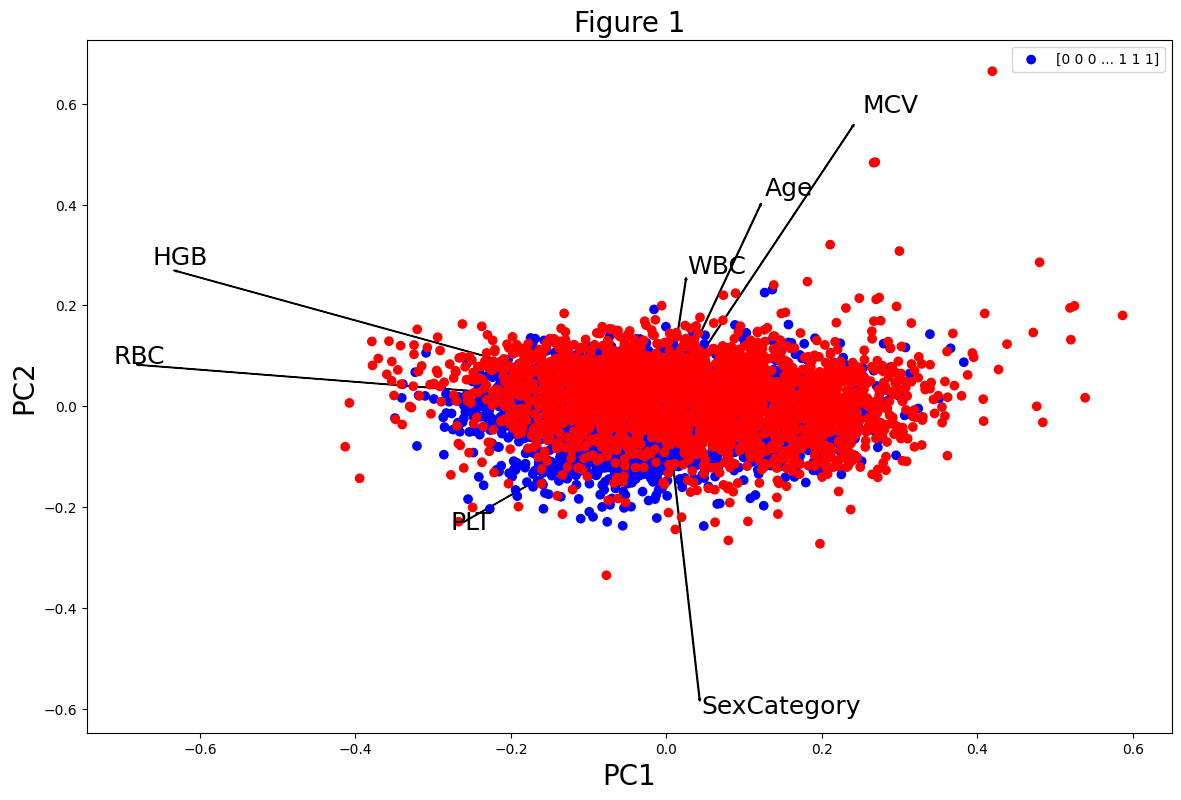

<Figure size 640x480 with 0 Axes>

In [16]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from dataAnalysis.Constants import FEATURES

##https://statisticsglobe.com/biplot-pca-python
scaler = StandardScaler()
 
scaler.fit(X_res)
 
scaled_data = scaler.transform(X_res)

PC1 = pca.fit_transform(scaled_data)[:,0]
PC2 = pca.fit_transform(scaled_data)[:,1]
ldngs = pca.components_

scalePC1 = 1.0/(PC1.max() - PC1.min())
scalePC2 = 1.0/(PC2.max() - PC2.min())
features = FEATURES

fig, ax = plt.subplots(figsize=(14, 9))
 
for i, feature in enumerate(features):
    ax.arrow(0, 0, ldngs[0, i], 
             ldngs[1, i])
    ax.text(ldngs[0, i] * 1.05, 
            ldngs[1, i] * 1.05, 
            feature, fontsize=18)
 

colors = ["red" if label else "blue" for label in y_res]
scatter = ax.scatter(PC1 * scalePC1,PC2 * scalePC2, color = colors, label=y_res)
# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes")
# ax.add_artist(legend1)
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_title('Figure 1', fontsize=20)
ax.legend()
plt.figure()